In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras

from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## Data augmentation for positive positive images (w/ crack)
##### Dataset2 is imbalanced: for pavements there are ~21.7k images without crack (train: 17.4k, test: 4345) and ~2.6k with crack (train: 2087, test: 521)
##### Many new images are generated using rotation and horizontal/vertical flip, saved in 'Train/augmentation' folder and moved into 'Train/Cracked' folder. The new training set is balanced (~17.4k images for each class)

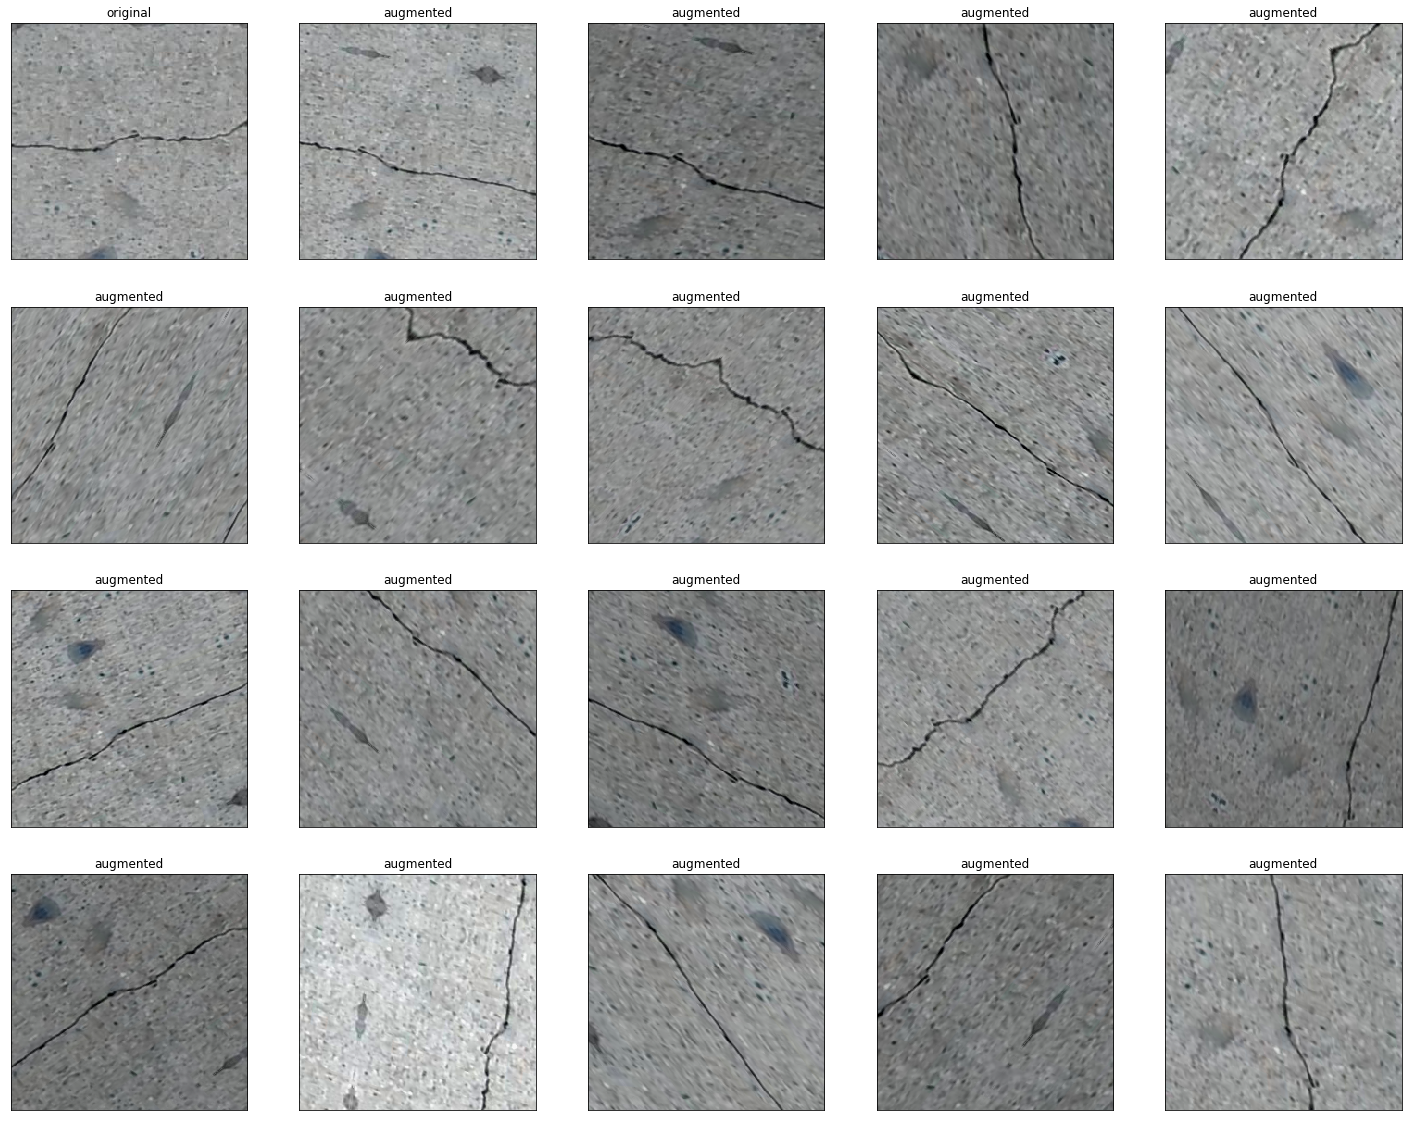

In [6]:
# example of data augmentation
path='/storage/Crack_detection/Dataset2/Crack_detection/Dataset2/Pavements/Train/Cracked'
list_images=os.listdir(path)
image_index=-2

image_original = load_img(os.path.join(path,list_images[image_index]))
image_original = img_to_array(image_original)
# expand dimension to one sample
img = np.expand_dims(image_original, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(
        height_shift_range=0.3,
        width_shift_range=0.3,
        shear_range=45,
        zoom_range=0.2,
        rotation_range=90,
        channel_shift_range=50.0,
        brightness_range=[0.6,1],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect' )
# prepare iterator
it = datagen.flow(img, batch_size=1)
# generate samples and plot
plt.figure(figsize=(25,20))
plt.subplot(4,5,1)
plt.imshow(image_original.astype('uint8'))
plt.title('original')
plt.xticks([])
plt.yticks([])
for i in range(19):
    plt.subplot(4,5,i+2)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
    plt.title('augmented')
    plt.xticks([])
    plt.yticks([])
# show the figure
plt.show()

In [7]:
# create images and save in augmentation folder, use aug prefix for generated images
path='/storage/Crack_detection/Dataset2/Crack_detection/Dataset2/Pavements/Train/'
path_save='/storage/Crack_detection/Dataset2/Crack_detection/Dataset2/Pavements/Train/Augmented'

img_height=256
img_width=256
batch_size=256

num_nc=len(os.listdir(os.path.join(path,'Non-cracked')))
num_c=len(os.listdir(os.path.join(path,'Cracked_aug')))

augmentation= np.floor(num_nc/num_c)
print(augmentation)
datagen = ImageDataGenerator(
        height_shift_range=0.3,
        width_shift_range=0.3,
        shear_range=45,
        zoom_range=0.2,
        rotation_range=90,
        channel_shift_range=50.0,
        brightness_range=[0.6,1],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect' )

img=datagen.flow_from_directory(
        path,
        save_to_dir=path_save,
        save_prefix='aug',
        seed=22,   
        target_size=(img_height, img_width), 
        batch_size=batch_size,
        save_format='jpg',
        classes=['Cracked_aug'])
#q=img.next()

while True:
    q=img.next()
    print(len(os.listdir(path_save)))
    if len(os.listdir(path_save)) > (num_nc-num_c):
        break

8.0
Found 2348 images belonging to 1 classes.
257
513
769
1025
1281
1537
1793
2049
2305
2349
2605
2861
3117
3373
3629
3885
4141
4397
4653
4697
4953
5209
5465
5721
5977
6233
6489
6745
7001
7045
7301
7557
7813
8069
8325
8581
8837
9093
9349
9393
9649
9905
10161
10417
10673
10929
11185
11441
11697
11741
11997
12253
12509
12765
13021
13277
13533
13789
14045
14089
14345
14601
14857
15113
15369
15625
15881
16137
16393
16437
16693
16949
17205
17461


In [8]:
# move images from augmentation folder to positive folder
path='/storage/Crack_detection/Dataset2/Crack_detection/Dataset2/Pavements/Train/'
count=0
for img in os.listdir(path_save):
    src_file=os.path.join(path,'Augmented',img)
    dst_file=os.path.join(path,'Cracked_aug',img)
    shutil.move(src_file, dst_file)        
    count+=1
    if count > (num_nc-num_c):
        break

In [12]:
# total number of train/test images
root='/storage/Crack_detection/Dataset2/Crack_detection/Dataset2/Pavements/'
print('Number of Positive Images in Training Directory is {}'.format(len(os.listdir(os.path.join(root, 'Train','Cracked_aug')))))
print('Number of Negative Images in Training Directory is {}'.format(len(os.listdir(os.path.join(root, 'Train','Non-cracked')))))
print('Number of Positive Images in Testing Directory is {}'.format(len(os.listdir(os.path.join(root, 'Test','Cracked')))))
print('Number of Negative Images in Testing Directory is {}'.format(len(os.listdir(os.path.join(root, 'Test','Non-cracked')))))

Number of Positive Images in Training Directory is 19555
Number of Negative Images in Training Directory is 19554
Number of Positive Images in Testing Directory is 260
Number of Negative Images in Testing Directory is 2172


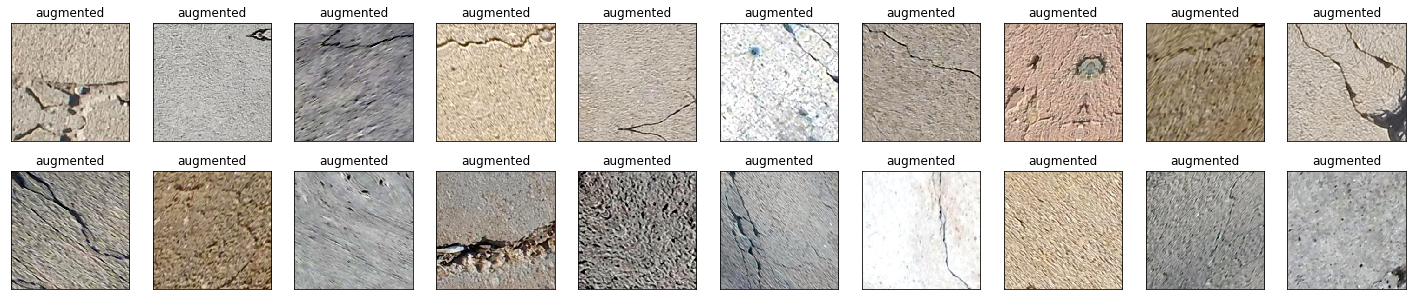

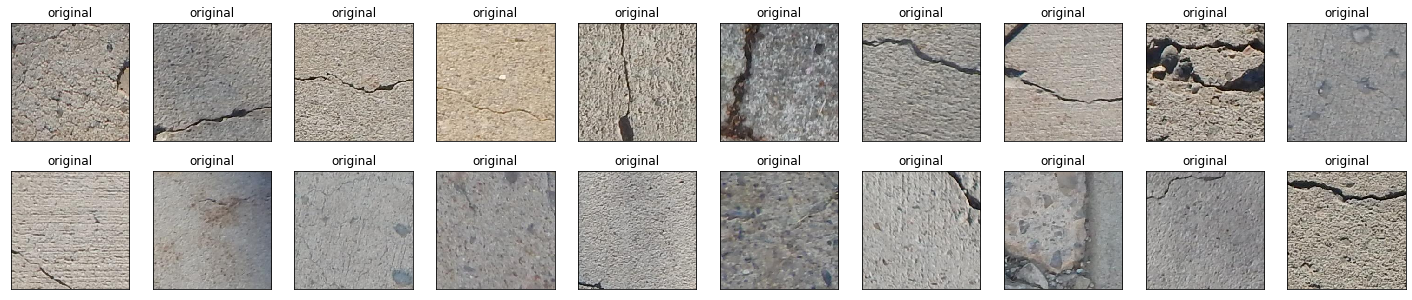

In [5]:
# plot examples of original and generated images
path_c='/storage/Crack_detection/Dataset2/Crack_detection/Dataset2/Pavements/Train/Cracked_aug'

_,_,list_img=next(os.walk(path_c))
list_original=[]
list_aug=[]
for img in list_img:
    if img[:3]=='aug':
        list_aug.append(img)
    else:
        list_original.append(img)
        
rnd_aug_idx=np.random.randint(len(list_aug), size=20)
rnd_original_idx=np.random.randint(len(list_original), size=20)

plt.figure(figsize=(25,5))
#plt.subplots_adjust(hspace =0.1)
image_idx=1
for idx in rnd_aug_idx:
    image=cv2.imread(os.path.join(path_c, list_aug[idx]))
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(2,10,image_idx)
    plt.imshow(image)
    plt.title('augmented')
    plt.xticks([])
    plt.yticks([])
    image_idx+=1
plt.show()
plt.figure(figsize=(25,5))
#plt.subplots_adjust(hspace =0.1)
image_idx=1
for idx in rnd_original_idx:
    image=cv2.imread(os.path.join(path_c, list_original[idx]))
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(2,10,image_idx)
    plt.imshow(image)
    plt.title('original')
    plt.xticks([])
    plt.yticks([])
    image_idx+=1
plt.show()